# Explian Trial 1

## explain BEFORE rejection

In [90]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from src.data_preprocessing import matrix_fourier_adjust

model = tf.keras.models.load_model("./src/models/HAR_trial_1.h5")
df_test = pd.read_csv("processed_test_data_activity_male_and_female.csv")

X_acc_x, X_acc_y, X_acc_z, X_gyro_x, X_gyro_y, X_gyro_z, class_labels = matrix_fourier_adjust(df_test)

X_test_inputs = [X_acc_x, X_acc_y, X_acc_z, X_gyro_x, X_gyro_y, X_gyro_z]
y_true = class_labels

y_pred = model.predict(X_test_inputs).argmax(axis=1)

# inputs for the surrogate model
X_combined = np.concatenate([X_acc_x, X_acc_y, X_acc_z, X_gyro_x, X_gyro_y, X_gyro_z], axis=1)

# split the data for surrogate training
train_indices, val_indices = train_test_split(range(len(df_test)), test_size=0.2, random_state=42)
df_train = df_test.iloc[train_indices]
df_val = df_test.iloc[val_indices]

# process training and validation data
X_acc_x_train, X_acc_y_train, X_acc_z_train, X_gyro_x_train, X_gyro_y_train, X_gyro_z_train, y_train = matrix_fourier_adjust(df_train)
X_acc_x_val, X_acc_y_val, X_acc_z_val, X_gyro_x_val, X_gyro_y_val, X_gyro_z_val, y_val = matrix_fourier_adjust(df_val)

# features for the surrogate model
X_train = np.concatenate([X_acc_x_train, X_acc_y_train, X_acc_z_train, X_gyro_x_train, X_gyro_y_train, X_gyro_z_train], axis=1)
X_val = np.concatenate([X_acc_x_val, X_acc_y_val, X_acc_z_val, X_gyro_x_val, X_gyro_y_val, X_gyro_z_val], axis=1)

X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

y_train = y_train.flatten()
y_val = y_val.flatten()

# train
surrogate = DecisionTreeClassifier(max_depth=5, random_state=42)
surrogate.fit(X_train, y_train)


 1/29 ━━━━━━━━━━━━━━━━━━━━ 6s 225ms/step

/Users/paulaperazzo/Documents/masters/ic2/ExAI - Final Project/.venv/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer', 'input_layer_1', 'input_layer_2', 'input_layer_3', 'input_layer_4', 'input_layer_5']. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


DecisionTreeClassifier(max_depth=5, random_state=42)

In [91]:
# mapping function to features
def map_feature_to_sensor(index, buffer_size=256):
    sensors = ["acc_x", "acc_y", "acc_z", "gyro_x", "gyro_y", "gyro_z"]
    sensor_index = index // buffer_size
    feature_position = index % buffer_size

    if sensor_index < len(sensors):
        return f"{sensors[sensor_index]}[{feature_position}]"
    else:
        raise ValueError(f"Index {index} is out of range for the defined sensors.")

feature_names = [map_feature_to_sensor(i, buffer_size=256) for i in range(X_train.shape[1])]

print(export_text(surrogate, feature_names=feature_names))


|--- acc_y[165] <= 1.11
|   |--- gyro_y[161] <= 0.48
|   |   |--- acc_z[142] <= 0.88
|   |   |   |--- gyro_y[26] <= 0.88
|   |   |   |   |--- class: 2.0
|   |   |   |--- gyro_y[26] >  0.88
|   |   |   |   |--- class: 3.0
|   |   |--- acc_z[142] >  0.88
|   |   |   |--- class: 3.0
|   |--- gyro_y[161] >  0.48
|   |   |--- acc_y[0] <= 20.61
|   |   |   |--- gyro_y[25] <= 1.45
|   |   |   |   |--- class: 2.0
|   |   |   |--- gyro_y[25] >  1.45
|   |   |   |   |--- acc_z[50] <= 4.31
|   |   |   |   |   |--- class: 3.0
|   |   |   |   |--- acc_z[50] >  4.31
|   |   |   |   |   |--- class: 4.0
|   |   |--- acc_y[0] >  20.61
|   |   |   |--- acc_y[160] <= 0.59
|   |   |   |   |--- acc_z[164] <= 0.13
|   |   |   |   |   |--- class: 2.0
|   |   |   |   |--- acc_z[164] >  0.13
|   |   |   |   |   |--- class: 3.0
|   |   |   |--- acc_y[160] >  0.59
|   |   |   |   |--- gyro_y[30] <= 1.17
|   |   |   |   |   |--- class: 2.0
|   |   |   |   |--- gyro_y[30] >  1.17
|   |   |   |   |   |--- class: 3.

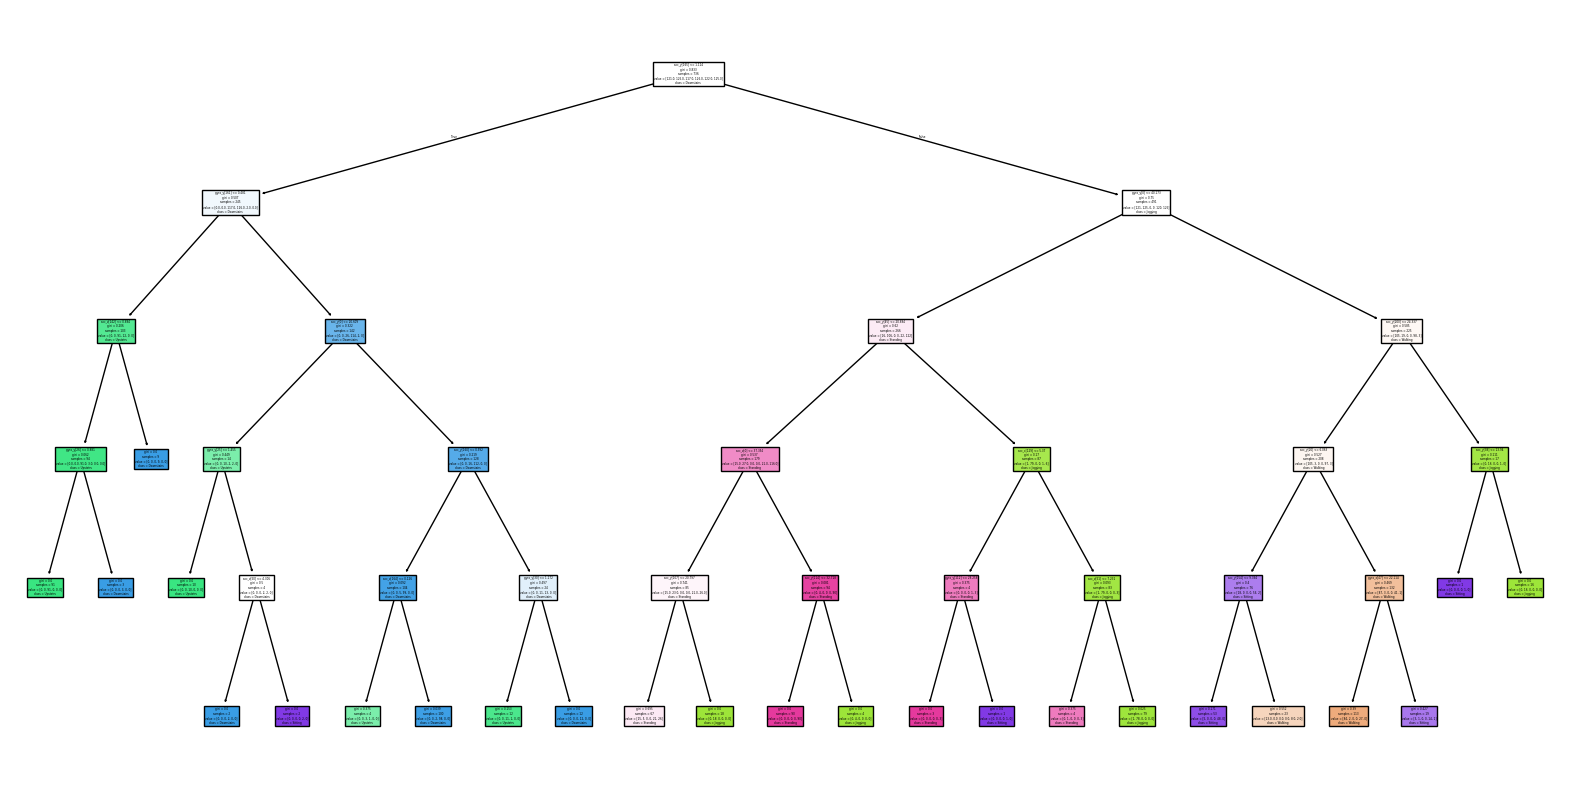

In [92]:
### plot decision tree

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(surrogate, filled=True, feature_names=[map_feature_to_sensor(i, buffer_size=256) for i in range(X_train.shape[1])], class_names=["Walking", "Jogging", "Upstairs", "Downstairs", "Sitting", "Standing"])
plt.show()

Surrogate Model Accuracy: 0.69


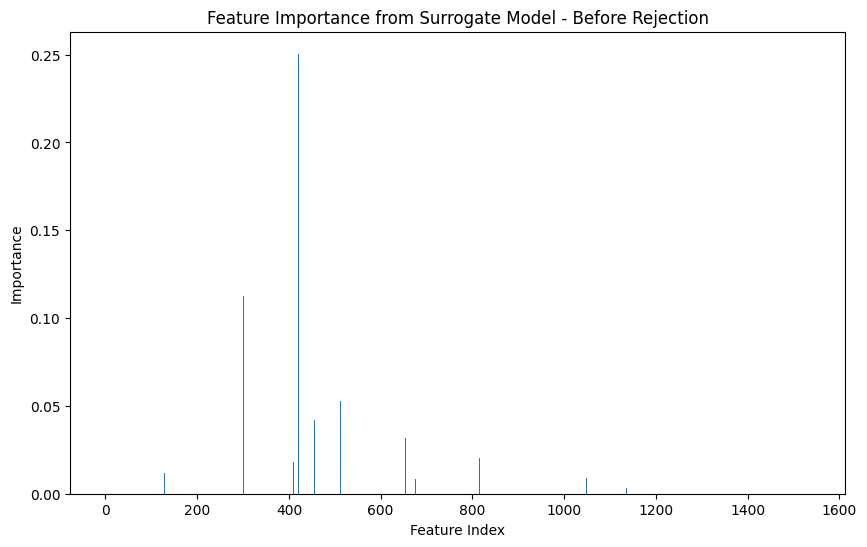

In [93]:
# Evaluate the surrogate model
y_surrogate_pred = surrogate.predict(X_val)
accuracy = accuracy_score(y_val, y_surrogate_pred)
print(f"Surrogate Model Accuracy: {accuracy:.2f}")

feature_importances = surrogate.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Feature Importance from Surrogate Model - Before Rejection")
plt.show()


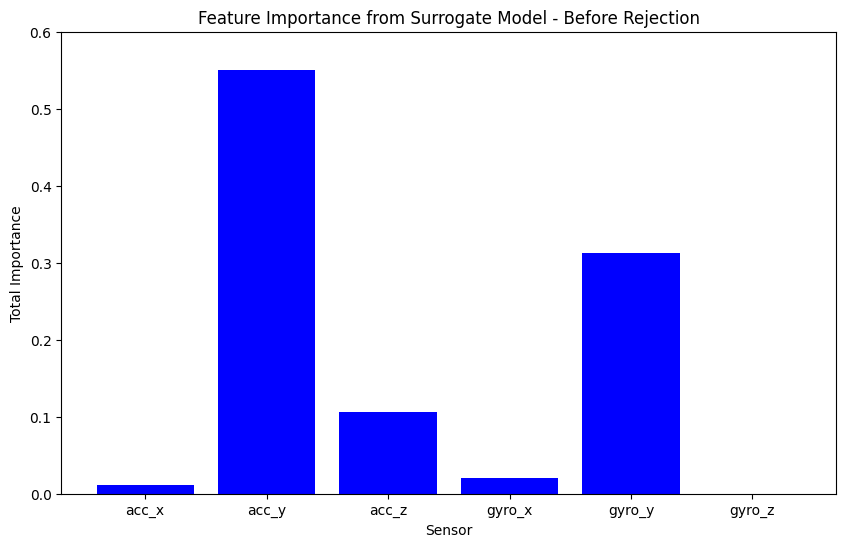

In [94]:
import matplotlib.pyplot as plt
import numpy as np

feature_importances = surrogate.feature_importances_

n_features_per_sensor = 256
sensor_labels = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

grouped_importances = [
    np.sum(feature_importances[i * n_features_per_sensor: (i + 1) * n_features_per_sensor])
    for i in range(len(sensor_labels))
]

plt.figure(figsize=(10, 6))
plt.bar(sensor_labels, grouped_importances, color='blue')
plt.xlabel("Sensor")
plt.ylabel("Total Importance")
plt.ylim(0, 0.6)
plt.title("Feature Importance from Surrogate Model - Before Rejection")
plt.show()


## AFTER rejection

In [74]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score
import tensorflow as tf
from src.data_preprocessing import matrix_fourier_adjust

model = tf.keras.models.load_model("./src/models/HAR_trial_1.h5")
df_test = pd.read_csv("processed_test_data_activity_male_and_female.csv")
X_acc_x, X_acc_y, X_acc_z, X_gyro_x, X_gyro_y, X_gyro_z, class_labels = matrix_fourier_adjust(df_test)

X_test_inputs = [X_acc_x, X_acc_y, X_acc_z, X_gyro_x, X_gyro_y, X_gyro_z]
y_true = np.array(class_labels)

# rejection functions

def calculate_entropy(predictions):
    return entropy(predictions, axis=1)

def predict_with_rejector(model, X_test, threshold):
    softmax_outputs = model.predict(X_test)
    entropies = calculate_entropy(softmax_outputs)

    predictions = np.argmax(softmax_outputs, axis=1)
    rejected = entropies > threshold
    accepted = ~rejected

    return predictions, accepted, rejected, entropies

entropy_threshold = 0.5
predictions, accepted, rejected, entropies = predict_with_rejector(model, X_test_inputs, entropy_threshold)

# evaluate accuracy on accepted instances
accuracy_with_rejection = accuracy_score(y_true[accepted], predictions[accepted])
reject_rate = np.mean(rejected)

print(f"Entropy threshold: {entropy_threshold}")
print(f"Accuracy with rejection: {accuracy_with_rejection}")
print(f"Rejection rate: {reject_rate * 100:.2f}%")

# inputs for the surrogate model (accepted samples only)
X_combined_accepted = np.concatenate([
    X_acc_x[accepted], X_acc_y[accepted], X_acc_z[accepted],
    X_gyro_x[accepted], X_gyro_y[accepted], X_gyro_z[accepted]
], axis=1)

X_combined_accepted = X_combined_accepted.reshape(X_combined_accepted.shape[0], -1)

surrogate = DecisionTreeClassifier(max_depth=5, random_state=42)
surrogate.fit(X_combined_accepted, predictions[accepted])

y_surrogate_pred = surrogate.predict(X_combined_accepted)
surrogate_accuracy = accuracy_score(predictions[accepted], y_surrogate_pred)

 8/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  

/Users/paulaperazzo/Documents/masters/ic2/ExAI - Final Project/.venv/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer', 'input_layer_1', 'input_layer_2', 'input_layer_3', 'input_layer_4', 'input_layer_5']. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Entropy threshold: 0.5
Accuracy with rejection: 0.9303977272727273
Rejection rate: 23.56%


In [75]:
print(f"Surrogate Model Accuracy: {surrogate_accuracy:.2f}")

def map_feature_to_sensor(index, buffer_size=256):
    sensors = ["acc_x", "acc_y", "acc_z", "gyro_x", "gyro_y", "gyro_z"]
    sensor_index = index // buffer_size
    feature_position = index % buffer_size

    if sensor_index < len(sensors):
        return f"{sensors[sensor_index]}[{feature_position}]"
    else:
        raise ValueError(f"Index {index} is out of range for the defined sensors.")

feature_names = [map_feature_to_sensor(i) for i in range(X_combined_accepted.shape[1])]

print("Surrogate Model Interpretation:")
print(export_text(surrogate, feature_names=feature_names))

Surrogate Model Accuracy: 0.90
Surrogate Model Interpretation:
|--- acc_y[44] <= 1.52
|   |--- gyro_y[179] <= 0.59
|   |   |--- gyro_y[11] <= 0.69
|   |   |   |--- class: 2
|   |   |--- gyro_y[11] >  0.69
|   |   |   |--- acc_y[16] <= 0.61
|   |   |   |   |--- class: 3
|   |   |   |--- acc_y[16] >  0.61
|   |   |   |   |--- class: 2
|   |--- gyro_y[179] >  0.59
|   |   |--- acc_y[0] <= 20.23
|   |   |   |--- acc_x[62] <= 1.20
|   |   |   |   |--- class: 2
|   |   |   |--- acc_x[62] >  1.20
|   |   |   |   |--- acc_z[50] <= 4.58
|   |   |   |   |   |--- class: 3
|   |   |   |   |--- acc_z[50] >  4.58
|   |   |   |   |   |--- class: 4
|   |   |--- acc_y[0] >  20.23
|   |   |   |--- acc_z[75] <= 0.14
|   |   |   |   |--- gyro_y[151] <= 0.65
|   |   |   |   |   |--- class: 3
|   |   |   |   |--- gyro_y[151] >  0.65
|   |   |   |   |   |--- class: 2
|   |   |   |--- acc_z[75] >  0.14
|   |   |   |   |--- gyro_z[221] <= 2.71
|   |   |   |   |   |--- class: 3
|   |   |   |   |--- gyro_z[221] 

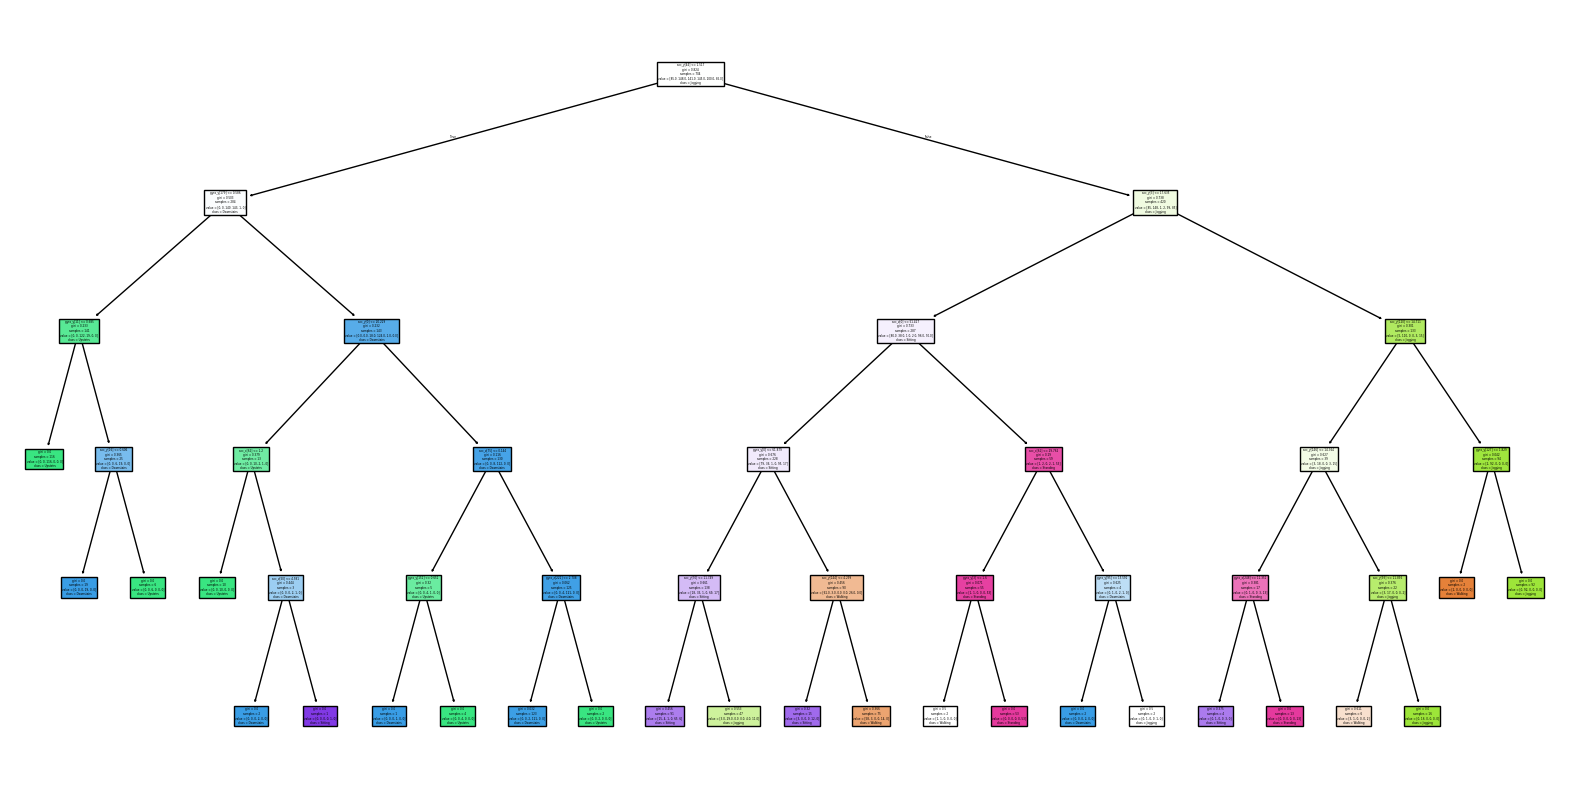

In [76]:
### plot decision tree

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(surrogate, filled=True, feature_names=feature_names, class_names=["Walking", "Jogging", "Upstairs", "Downstairs", "Sitting", "Standing"])
plt.show()

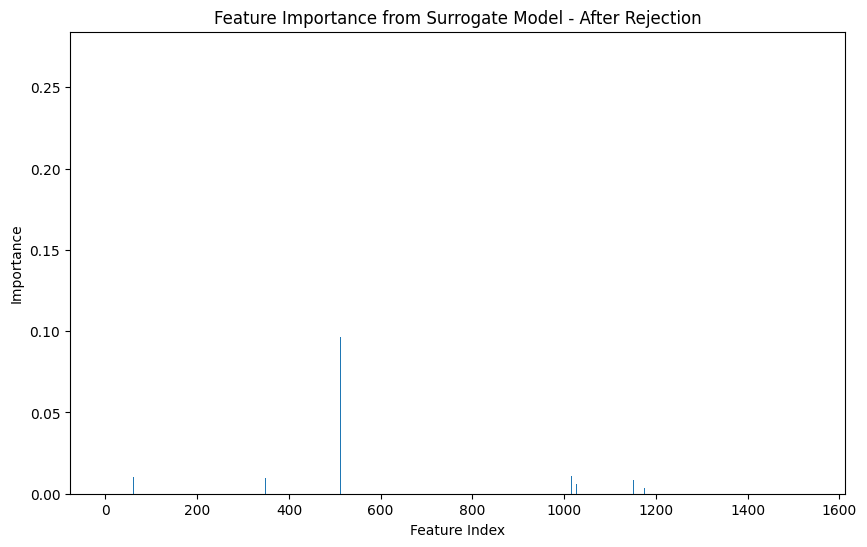

In [77]:
feature_importances = surrogate.feature_importances_

plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Feature Importance from Surrogate Model - After Rejection")
plt.show()


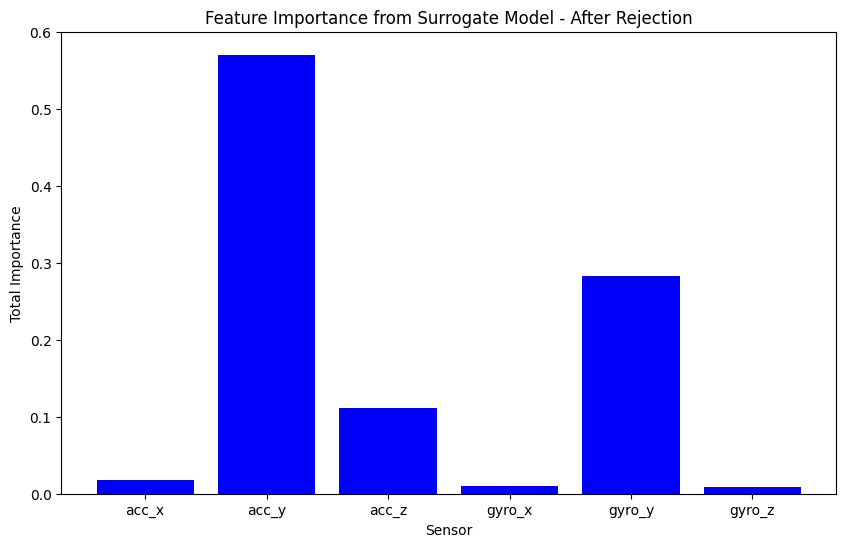

In [78]:
import matplotlib.pyplot as plt
import numpy as np

feature_importances = surrogate.feature_importances_

n_features_per_sensor = 256
sensor_labels = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

grouped_importances = [
    np.sum(feature_importances[i * n_features_per_sensor: (i + 1) * n_features_per_sensor])
    for i in range(len(sensor_labels))
]

plt.figure(figsize=(10, 6))
plt.bar(sensor_labels, grouped_importances, color='blue')
plt.xlabel("Sensor")
plt.ylabel("Total Importance")
plt.ylim(0, 0.6)
plt.title("Feature Importance from Surrogate Model - After Rejection")
plt.show()


# Explain Trial 2

## Before Rejection

In [79]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from src.data_preprocessing import matrix_fourier_adjust

model = tf.keras.models.load_model("./src/models/HAR_trial_2.h5")
df_test = pd.read_csv("processed_test_data_trial_2.csv")

X_acc_x, X_acc_y, X_acc_z, X_gyro_x, X_gyro_y, X_gyro_z, class_labels = matrix_fourier_adjust(df_test)

X_test_inputs = [X_acc_x, X_acc_y, X_acc_z, X_gyro_x, X_gyro_y, X_gyro_z]
y_true = class_labels

y_pred = model.predict(X_test_inputs).argmax(axis=1)

# inputs for the surrogate model
X_combined = np.concatenate([X_acc_x, X_acc_y, X_acc_z, X_gyro_x, X_gyro_y, X_gyro_z], axis=1)

# split the data for surrogate training
train_indices, val_indices = train_test_split(range(len(df_test)), test_size=0.2, random_state=42)
df_train = df_test.iloc[train_indices]
df_val = df_test.iloc[val_indices]

# process training and validation data
X_acc_x_train, X_acc_y_train, X_acc_z_train, X_gyro_x_train, X_gyro_y_train, X_gyro_z_train, y_train = matrix_fourier_adjust(df_train)
X_acc_x_val, X_acc_y_val, X_acc_z_val, X_gyro_x_val, X_gyro_y_val, X_gyro_z_val, y_val = matrix_fourier_adjust(df_val)

# features for the surrogate model
X_train = np.concatenate([X_acc_x_train, X_acc_y_train, X_acc_z_train, X_gyro_x_train, X_gyro_y_train, X_gyro_z_train], axis=1)
X_val = np.concatenate([X_acc_x_val, X_acc_y_val, X_acc_z_val, X_gyro_x_val, X_gyro_y_val, X_gyro_z_val], axis=1)

X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

y_train = y_train.flatten()
y_val = y_val.flatten()

# train
surrogate = DecisionTreeClassifier(max_depth=5, random_state=42)
surrogate.fit(X_train, y_train)


 9/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  

/Users/paulaperazzo/Documents/masters/ic2/ExAI - Final Project/.venv/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer', 'input_layer_1', 'input_layer_2', 'input_layer_3', 'input_layer_4', 'input_layer_5']. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


DecisionTreeClassifier(max_depth=5, random_state=42)

In [80]:
# mapping function to features
def map_feature_to_sensor(index, buffer_size=256):
    sensors = ["acc_x", "acc_y", "acc_z", "gyro_x", "gyro_y", "gyro_z"]
    sensor_index = index // buffer_size
    feature_position = index % buffer_size

    if sensor_index < len(sensors):
        return f"{sensors[sensor_index]}[{feature_position}]"
    else:
        raise ValueError(f"Index {index} is out of range for the defined sensors.")

feature_names = [map_feature_to_sensor(i, buffer_size=256) for i in range(X_train.shape[1])]

print(export_text(surrogate, feature_names=feature_names))

|--- gyro_x[30] <= 2.27
|   |--- gyro_y[220] <= 0.77
|   |   |--- gyro_y[246] <= 1.08
|   |   |   |--- gyro_y[62] <= 1.16
|   |   |   |   |--- acc_x[134] <= 1.72
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- acc_x[134] >  1.72
|   |   |   |   |   |--- class: 2.0
|   |   |   |--- gyro_y[62] >  1.16
|   |   |   |   |--- gyro_x[27] <= 1.35
|   |   |   |   |   |--- class: 2.0
|   |   |   |   |--- gyro_x[27] >  1.35
|   |   |   |   |   |--- class: 1.0
|   |   |--- gyro_y[246] >  1.08
|   |   |   |--- gyro_z[132] <= 1.35
|   |   |   |   |--- acc_y[173] <= 0.04
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- acc_y[173] >  0.04
|   |   |   |   |   |--- class: 2.0
|   |   |   |--- gyro_z[132] >  1.35
|   |   |   |   |--- class: 1.0
|   |--- gyro_y[220] >  0.77
|   |   |--- acc_y[0] <= 14.77
|   |   |   |--- gyro_z[89] <= 1.87
|   |   |   |   |--- class: 1.0
|   |   |   |--- gyro_z[89] >  1.87
|   |   |   |   |--- gyro_z[242] <= 10.50
|   |   |   |   |   |--- class: 4.0
|   |

Surrogate Model Accuracy: 0.77


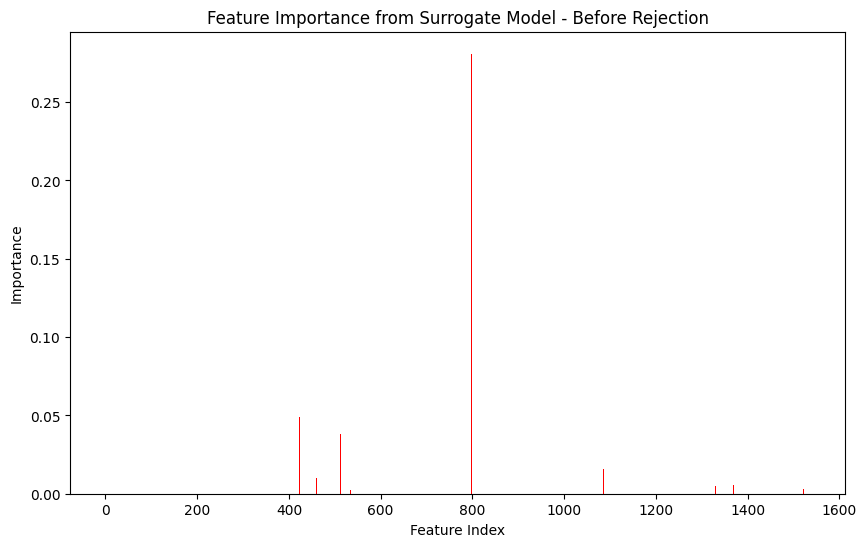

In [81]:
# Evaluate the surrogate model

import matplotlib.pyplot as plt

y_surrogate_pred = surrogate.predict(X_val)
accuracy = accuracy_score(y_val, y_surrogate_pred)
print(f"Surrogate Model Accuracy: {accuracy:.2f}")

feature_importances = surrogate.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances, color="red")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Feature Importance from Surrogate Model - Before Rejection")
plt.show()

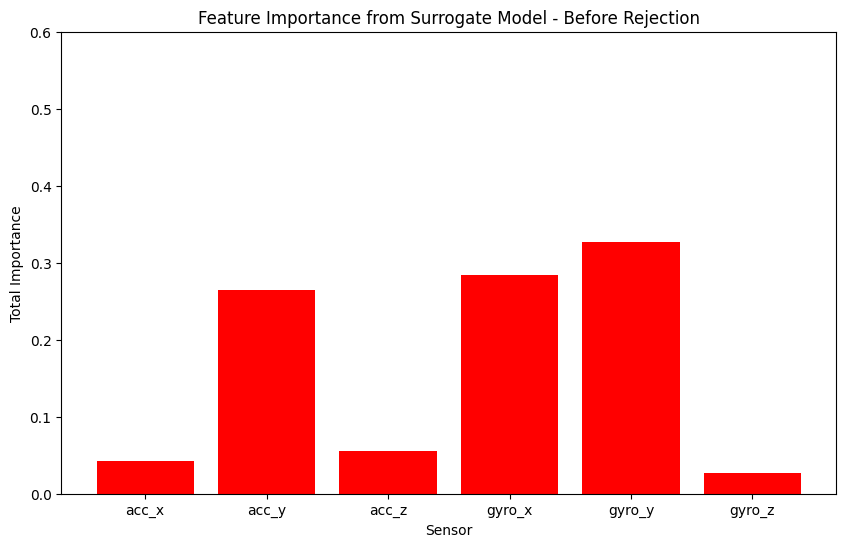

In [82]:
import matplotlib.pyplot as plt
import numpy as np

feature_importances = surrogate.feature_importances_

n_features_per_sensor = 256
sensor_labels = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

grouped_importances = [
    np.sum(feature_importances[i * n_features_per_sensor: (i + 1) * n_features_per_sensor])
    for i in range(len(sensor_labels))
]

plt.figure(figsize=(10, 6))
plt.bar(sensor_labels, grouped_importances, color='red')
plt.xlabel("Sensor")
plt.ylabel("Total Importance")
plt.ylim(0, 0.6)
plt.title("Feature Importance from Surrogate Model - Before Rejection")
plt.show()


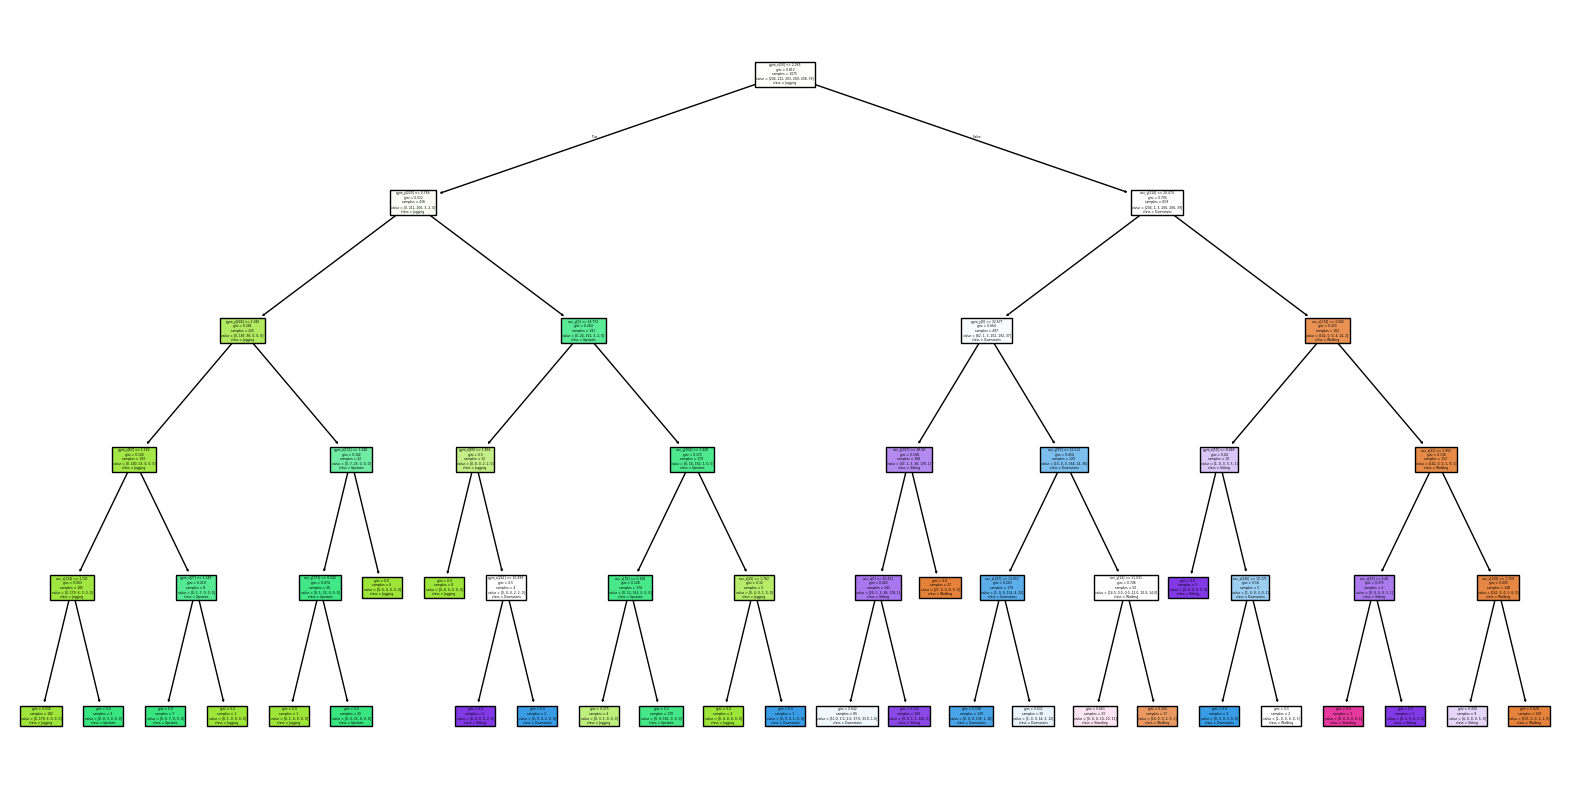

In [83]:
### plot decision tree

from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(surrogate, filled=True, feature_names=[map_feature_to_sensor(i, buffer_size=256) for i in range(X_train.shape[1])], class_names=["Walking", "Jogging", "Upstairs", "Downstairs", "Sitting", "Standing"])
plt.show()

## After Rejection

In [84]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score
import tensorflow as tf
from src.data_preprocessing import matrix_fourier_adjust

model = tf.keras.models.load_model("./src/models/HAR_trial_2.h5")
df_test = pd.read_csv("processed_test_data_trial_2.csv")
X_acc_x, X_acc_y, X_acc_z, X_gyro_x, X_gyro_y, X_gyro_z, class_labels = matrix_fourier_adjust(df_test)

X_test_inputs = [X_acc_x, X_acc_y, X_acc_z, X_gyro_x, X_gyro_y, X_gyro_z]
y_true = np.array(class_labels)

# rejection functions

def calculate_entropy(predictions):
    return entropy(predictions, axis=1)

def predict_with_rejector(model, X_test, threshold):
    softmax_outputs = model.predict(X_test)
    entropies = calculate_entropy(softmax_outputs)

    predictions = np.argmax(softmax_outputs, axis=1)
    rejected = entropies > threshold
    accepted = ~rejected

    return predictions, accepted, rejected, entropies

entropy_threshold = 0.1
predictions, accepted, rejected, entropies = predict_with_rejector(model, X_test_inputs, entropy_threshold)

# evaluate accuracy on accepted instances
accuracy_with_rejection = accuracy_score(y_true[accepted], predictions[accepted])
reject_rate = np.mean(rejected)

print(f"Entropy threshold: {entropy_threshold}")
print(f"Accuracy with rejection: {accuracy_with_rejection}")
print(f"Rejection rate: {reject_rate * 100:.2f}%")

11/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  

/Users/paulaperazzo/Documents/masters/ic2/ExAI - Final Project/.venv/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer', 'input_layer_1', 'input_layer_2', 'input_layer_3', 'input_layer_4', 'input_layer_5']. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Entropy threshold: 0.1
Accuracy with rejection: 0.9625506072874493
Rejection rate: 26.49%


In [85]:
# inputs for the surrogate model (accepted samples only)
X_combined_accepted = np.concatenate([
    X_acc_x[accepted], X_acc_y[accepted], X_acc_z[accepted],
    X_gyro_x[accepted], X_gyro_y[accepted], X_gyro_z[accepted]
], axis=1)

X_combined_accepted = X_combined_accepted.reshape(X_combined_accepted.shape[0], -1)

surrogate = DecisionTreeClassifier(max_depth=5, random_state=42)
surrogate.fit(X_combined_accepted, predictions[accepted])

y_surrogate_pred = surrogate.predict(X_combined_accepted)
surrogate_accuracy = accuracy_score(predictions[accepted], y_surrogate_pred)

In [86]:
print(f"Surrogate Model Accuracy: {surrogate_accuracy:.2f}")

def map_feature_to_sensor(index, buffer_size=256):
    sensors = ["acc_x", "acc_y", "acc_z", "gyro_x", "gyro_y", "gyro_z"]
    sensor_index = index // buffer_size
    feature_position = index % buffer_size

    if sensor_index < len(sensors):
        return f"{sensors[sensor_index]}[{feature_position}]"
    else:
        raise ValueError(f"Index {index} is out of range for the defined sensors.")

feature_names = [map_feature_to_sensor(i) for i in range(X_combined_accepted.shape[1])]

print("Surrogate Model Interpretation:")
print(export_text(surrogate, feature_names=feature_names))

Surrogate Model Accuracy: 0.99
Surrogate Model Interpretation:
|--- acc_y[20] <= 1.17
|   |--- gyro_y[67] <= 0.72
|   |   |--- gyro_y[127] <= 0.89
|   |   |   |--- gyro_y[114] <= 1.17
|   |   |   |   |--- class: 1
|   |   |   |--- gyro_y[114] >  1.17
|   |   |   |   |--- class: 2
|   |   |--- gyro_y[127] >  0.89
|   |   |   |--- gyro_z[114] <= 1.60
|   |   |   |   |--- class: 2
|   |   |   |--- gyro_z[114] >  1.60
|   |   |   |   |--- class: 1
|   |--- gyro_y[67] >  0.72
|   |   |--- gyro_y[54] <= 0.40
|   |   |   |--- acc_z[50] <= 0.64
|   |   |   |   |--- class: 1
|   |   |   |--- acc_z[50] >  0.64
|   |   |   |   |--- class: 2
|   |   |--- gyro_y[54] >  0.40
|   |   |   |--- acc_y[6] <= 1.16
|   |   |   |   |--- acc_z[231] <= 0.10
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- acc_z[231] >  0.10
|   |   |   |   |   |--- class: 2
|   |   |   |--- acc_y[6] >  1.16
|   |   |   |   |--- acc_z[94] <= 5.11
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- acc_z[94] >  5.11
| 

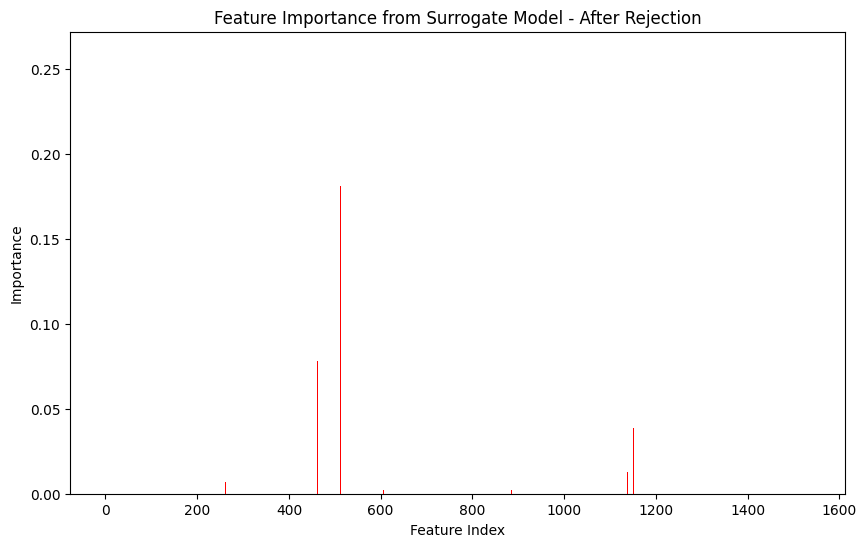

In [87]:
feature_importances = surrogate.feature_importances_

plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances, color="red")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Feature Importance from Surrogate Model - After Rejection")
plt.show()


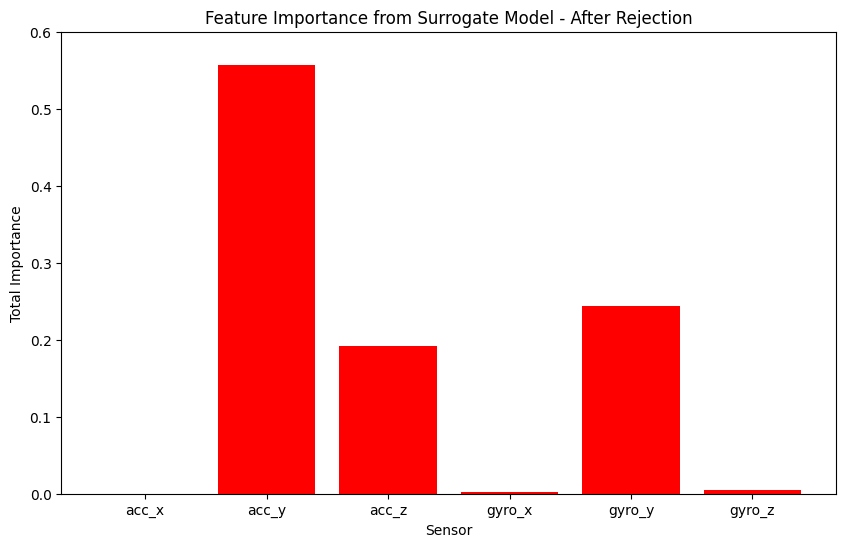

In [88]:
import matplotlib.pyplot as plt
import numpy as np

feature_importances = surrogate.feature_importances_

n_features_per_sensor = 256
sensor_labels = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

grouped_importances = [
    np.sum(feature_importances[i * n_features_per_sensor: (i + 1) * n_features_per_sensor])
    for i in range(len(sensor_labels))
]

plt.figure(figsize=(10, 6))
plt.bar(sensor_labels, grouped_importances, color='red')
plt.xlabel("Sensor")
plt.ylabel("Total Importance")
plt.ylim(0, 0.6)
plt.title("Feature Importance from Surrogate Model - After Rejection")
plt.show()


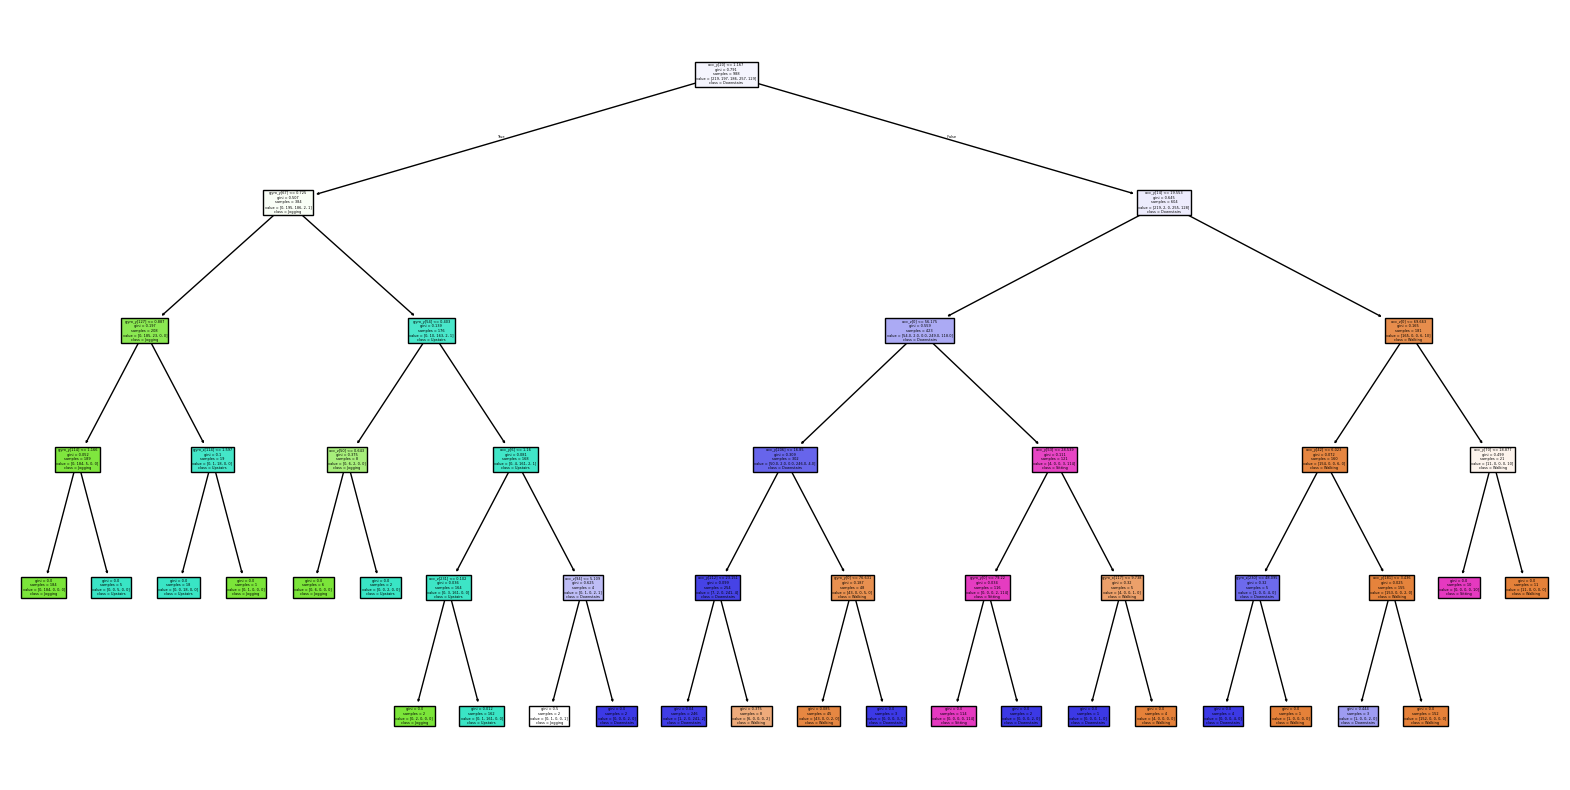

In [89]:
### plot decision tree

from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(surrogate, filled=True, feature_names=feature_names, class_names=["Walking", "Jogging", "Upstairs", "Downstairs", "Sitting", "Standing"])
plt.show()